### Imports / Authenticate

In [1]:
import ee 
import folium
from datetime import datetime as dt
from IPython.display import Image

In [3]:
ee.Initialize()
ee.Authenticate()

Enter verification code: 4/1AY0e-g7seW8GChUpv5esFPPJj_ARvy6OLKioFM8k1LEWguu9tBd7NKmWOpM

Successfully saved authorization token.


### Get collection

In [4]:
# map log latt :
Ituna_map = folium.Map(location=[48.8, 2.7], zoom_start=12)
Ituna_map

In [7]:
def image_coll_point(date_start, date_end, point):
    '''
    return the collection of image on "LANDSAT/LC08/C01/T1_SR"
    between start date and end date ('2019-09-21','2019-12-21')
    on the Geometry.Point
    '''
    landsat = ee.ImageCollection("LANDSAT/LC08/C01/T1_SR")

    # filter area
    landsat_AOI = landsat.filterBounds(point)

    # choose dates
    return landsat_AOI.filterDate(date_start,date_end)
    

In [8]:
point = ee.Geometry.Point([2.7, 48.8])
landsat_AOI = image_coll_point('2019-09-21','2019-12-21', point)

print('Total number:', landsat_AOI.size().getInfo())

Total number: 6


### Explore one image

In [9]:
first_image = landsat_AOI.first()

# the least cloudy image
least_cloudy = ee.Image(landsat_AOI.sort('CLOUD_COVER').first())

least_cloudy.getInfo()

# how cloudy is it?
print('Cloud Cover (%):', least_cloudy.get('CLOUD_COVER').getInfo())

# when was this image taken?
date = ee.Date(first_image.get('system:time_start'))
time = date.getInfo()['value']/1000.

print ('first :' , dt.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))

date = ee.Date(least_cloudy.get('system:time_start'))
time = date.getInfo()['value']/1000.
print ('cloudy :' , dt.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S'))


Cloud Cover (%): 6.78
first : 2019-11-02 10:35:02
cloudy : 2019-12-04 10:34:58


In [15]:
parameters = {'min': 0,
              'max': 1000,
              'dimensions': 512,
              'bands': ['B4', 'B3', 'B2'],
              'region': least_cloudy.geometry()}

In [16]:
Image(url = least_cloudy.getThumbUrl(parameters))

### Export to file

In [28]:
OPTICAL_BANDS = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7']
THERMAL_BANDS = ['B10', 'B11']
BEFORE_BANDS = OPTICAL_BANDS + THERMAL_BANDS
AFTER_BANDS = [str(s) + '_1' for s in BEFORE_BANDS]
BANDS = BEFORE_BANDS + AFTER_BANDS


In [29]:
def maskL8sr(image):
  cloudShadowBitMask = ee.Number(2).pow(3).int()
  cloudsBitMask = ee.Number(2).pow(5).int()
  qa = image.select('pixel_qa')
  mask1 = qa.bitwiseAnd(cloudShadowBitMask).eq(0).And(
    qa.bitwiseAnd(cloudsBitMask).eq(0))
  mask2 = image.mask().reduce('min')
  mask3 = image.select(OPTICAL_BANDS).gt(0).And(
          image.select(OPTICAL_BANDS).lt(10000)).reduce('min')
  mask = mask1.And(mask2).And(mask3)
  return image.select(OPTICAL_BANDS).divide(10000).addBands(
          image.select(THERMAL_BANDS).divide(10).clamp(273.15, 373.15)
            .subtract(273.15).divide(100)).updateMask(mask)

# Make "before" and "after" composites.
composite1 = landsat_AOI.map(maskL8sr).median()


In [35]:
export_image = 'projects/google/logistic_demo_image'
composite1 = least_cloudy.select(OPTICAL_BANDS)

image_task = ee.batch.Export.image.toDrive(
  image = composite1, 
  description = 'demo_image', 
  folder = export_image, 
  region = least_cloudy.geometry(),
    fileFormat= 'GeoTIFF',
  scale = 30,
#   maxPixels = 1e10
)

image_task.start()

In [53]:
#Load a landsat image and select three bands.
landsat = ee.Image('LANDSAT/LC08/C01/T1_TOA/LC08_123032_20140515').select(['B4', 'B3', 'B2'])
# image_rgb = landsat.visualize(**{'bands': ['B5', 'B4', 'B3'], 'max': 0.5})

# Create a geometry representing an export region.
geometry = ee.Geometry.Rectangle([116.2621, 39.8412, 116.4849, 40.01236])

#Export the image, specifying scale and region.
image_task = ee.batch.Export.image.toDrive(
  image= landsat,
  folder = export_image, 
 description= 'imageToDriveExample6',
  scale= 30,
  region= geometry
)
image_task.start()

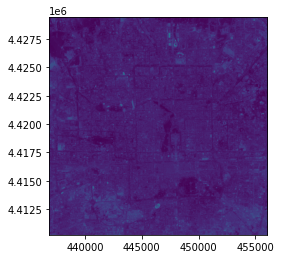

<AxesSubplot:>

In [54]:
import rasterio
from rasterio.plot import show
fp = 'imageToDriveExample6.tif'
img = rasterio.open(fp)
show(img)

In [55]:
type(img)

rasterio.io.DatasetReader

### Add image in folium

In [115]:
ndvi = least_cloudy.normalizedDifference(['B5', 'B4'])

In [116]:
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
      tiles=map_id_dict['tile_fetcher'].url_format,
      attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name=name,
      overlay=True,
      control=True
  ).add_to(self)

folium.Map.add_ee_layer = add_ee_layer

In [129]:
palette = ['red', 'yellow', 'green']
ndvi_parameters = {'bands':['B11', 'B4', 'B7'],
                    'min': 0,
                   'max': 4000,
#                    'dimensions': 512,
#                   'palette': palette,
                   'region': Ituna_AOI}
Ituna_map.add_ee_layer(least_cloudy ,ndvi_parameters, 'test')
Ituna_map